In [1]:
from pathlib import Path
import random
import typing as tp
from itertools import chain
from itertools import repeat
from math import ceil

import cv2
import matplotlib.pyplot as plt
import torch
from sklearn import metrics
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm

In [2]:
DATASET_ROOT = Path(r"D:\Datasets\archive\simpsons_dataset")
BATCH_SIZE = 120
LR = 0.01
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

random.seed = 42
torch.manual_seed(42);

In [3]:
class SimpsonsDataset(data.Dataset):
    def __init__(self, root: Path, *, size: int) -> None:
        super().__init__()

        self.images = list(root.rglob("*.jpg"))
        self.classes = sorted(list(set(map(lambda path: path.parent.name, self.images))))
        self.num_classes = len(self.classes)
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((size, size), antialias=True),
        ])

    def __len__(self):
        return len(self.images)

    def _one_hot(self, label: int):
        vec = torch.zeros(self.num_classes, dtype=torch.float32)
        vec[label] = 1.0

        return vec

    def __getitem__(self, index):
        image_path = self.images[index]
        image = self.transforms(
            cv2.cvtColor(cv2.imread(image_path.as_posix()), cv2.COLOR_BGR2RGB)
        )
        label = self._one_hot(self.classes.index(image_path.parent.name))

        return image, label

In [4]:
dataset = SimpsonsDataset(DATASET_ROOT, size=32)

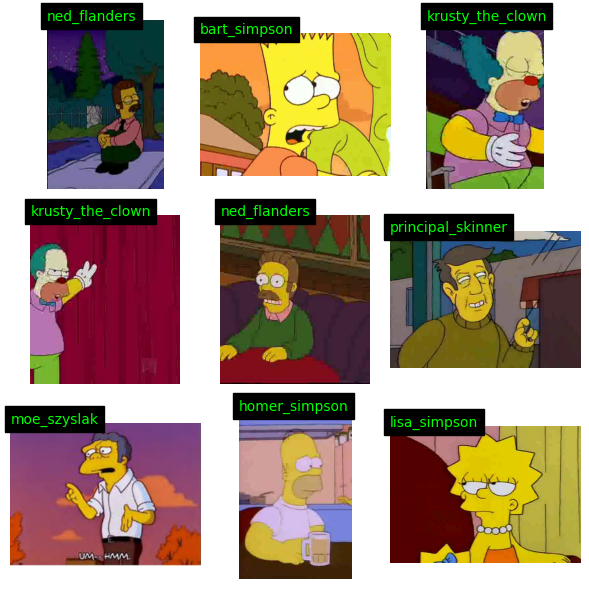

In [5]:
num_images = 9
images_to_plot = random.sample(dataset.images, num_images)

ncols = round(num_images ** 0.5)
nrows = ceil(num_images / ncols)

fig, axes = plt.subplots(nrows, ncols, dpi=100, figsize=(ncols*2, nrows*2), tight_layout=True)

for ax in axes.flatten():
    ax.set_axis_off()

for ax, image_to_plot in zip(axes.flatten(), images_to_plot):
    image = plt.imread(image_to_plot)
    label = image_to_plot.parent.name
    ax.text(0, 0, label, color="lime", backgroundcolor="black")
    ax.imshow(image)

In [6]:
train_set_size = int(0.8 * len(dataset))
test_set_size = len(dataset) - train_set_size

train_set, test_set = data.random_split(dataset, (train_set_size, test_set_size))

train_dataloader = data.DataLoader(train_set, BATCH_SIZE, shuffle=True)
test_dataloader = data.DataLoader(test_set, BATCH_SIZE, shuffle=False)

In [7]:
class BasicBlock(nn.Module):
    _expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self._expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self._expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self._expansion*planes),
            )

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(data)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(data)
        out = F.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, blocks_config: tp.Sequence[int], *, num_classes: int = 10) -> None:
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        layers: list[nn.Module] = []
        for out_features, num_blocks, stride in zip(
            [64, 128, 256, 512],
            blocks_config,
            [1, 2, 2, 2],
        ):
            layers.append(self._make_layer(out_features, num_blocks, stride))

        self.layers = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*BasicBlock._expansion, num_classes)

    def _make_layer(self, planes: int, num_blocks, stride):
        strides = chain([stride], repeat(1, num_blocks - 1))
        layers: list[nn.Module] = []

        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock._expansion

        return nn.Sequential(*layers)

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(data)))
        out = self.layers(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [8]:
resnet18 = ResNet([2,2,2,2], num_classes=dataset.num_classes)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

In [9]:
def get_correct_num(predictions, ground_truth) -> int:
    with torch.no_grad():
        correct = (
            (predictions.argmax(dim=1) == ground_truth.argmax(dim=1))
            .cpu()
            .detach()
            .to(torch.int32)
            .sum()
            .item()
        )

    return correct

In [10]:
loss = torch.nn.CrossEntropyLoss(reduction='mean')

model = ResNet([2, 2, 2, 2], num_classes=len(dataset.classes))
model.to(DEVICE)
model.train()

optimizer = torch.optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    [7],
    gamma=0.1,
)

for epoch_no in range(1, EPOCHS + 1):
    running_loss = 0
    correct = 0
    denominator = 0
    train_mean_loss = 0

    for signals, ground_truth in tqdm(
        train_dataloader,
        desc='Train batches',
        total=len(train_dataloader),
    ):
        optimizer.zero_grad()

        signals = signals.to(DEVICE)
        ground_truth = ground_truth.to(DEVICE)

        predictions = model(signals)
        loss_value = loss(predictions, ground_truth)
        loss_value.backward()

        optimizer.step()

        correct += get_correct_num(predictions, ground_truth)
        denominator += len(predictions)
        mean_loss = torch.mean(loss_value.cpu().detach()).item()
        running_loss += mean_loss

        train_mean_loss = running_loss / len(train_dataloader)

    scheduler.step()

    accuracy = correct / denominator

    print(
        f'Epoch: {epoch_no:02d} '
        f'| train loss: {train_mean_loss:.4f} '
        f'| accuracy: {accuracy:.4f}\n'
    )

Train batches: 100%|██████████| 280/280 [01:28<00:00,  3.18it/s]


Epoch: 01 | train loss: 2.4518 | accuracy: 0.3210



Train batches: 100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch: 02 | train loss: 1.1995 | accuracy: 0.6620



Train batches: 100%|██████████| 280/280 [01:27<00:00,  3.19it/s]


Epoch: 03 | train loss: 0.6958 | accuracy: 0.7991



Train batches: 100%|██████████| 280/280 [01:26<00:00,  3.23it/s]


Epoch: 04 | train loss: 0.4022 | accuracy: 0.8830



Train batches: 100%|██████████| 280/280 [01:26<00:00,  3.22it/s]


Epoch: 05 | train loss: 0.2492 | accuracy: 0.9276



Train batches: 100%|██████████| 280/280 [01:26<00:00,  3.22it/s]


Epoch: 06 | train loss: 0.1569 | accuracy: 0.9523



Train batches: 100%|██████████| 280/280 [01:27<00:00,  3.20it/s]


Epoch: 07 | train loss: 0.1283 | accuracy: 0.9611



Train batches: 100%|██████████| 280/280 [01:28<00:00,  3.16it/s]


Epoch: 08 | train loss: 0.0260 | accuracy: 0.9934



Train batches: 100%|██████████| 280/280 [01:27<00:00,  3.21it/s]


Epoch: 09 | train loss: 0.0078 | accuracy: 0.9991



Train batches: 100%|██████████| 280/280 [01:28<00:00,  3.18it/s]

Epoch: 10 | train loss: 0.0052 | accuracy: 0.9994



In [11]:
model.eval()

prediction_batches = []
ground_truth_batches = []

with torch.no_grad():
    for data, ground_truth in test_dataloader:
        data = data.to(DEVICE)
        ground_truth = ground_truth.to(DEVICE)
        predictions = model(data)

        prediction_batches.append(predictions)
        ground_truth_batches.append(ground_truth)

predictions = torch.cat(prediction_batches)
ground_truth = torch.cat(ground_truth_batches)



f1_score = metrics.f1_score(ground_truth.cpu().argmax(dim=1), predictions.cpu().argmax(dim=1), average="weighted")
print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.9818
